Models are trained on different categories

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import json
import os

# Prep data

In [4]:
pheme = pd.read_csv('datasets\pheme.csv')
#pheme.rename(columns = {"Unnamed: 0":"entry"}, inplace=True)
pheme.head()

,Unnamed: 0,text,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target
0,0,break least dead injur gunman open fire offic ...,Wed Jan 07 11:06:08 +0000 2015,14,159,H_E_Samuel,Tue Oct 04 09:36:17 +0000 2011,1628,246,1901,False,False,0,[],charliehebdo-all-rnr-threads,True
1,1,franc peopl dead shoot hq satir weekli newspap...,Wed Jan 07 11:07:51 +0000 2015,38,486,euronews,Wed Mar 18 12:57:11 +0000 2009,129573,337,48440,False,True,1,[],charliehebdo-all-rnr-threads,True
2,2,ten kill shoot headquart french satir weekli c...,Wed Jan 07 11:08:09 +0000 2015,15,127,Channel4News,Mon Apr 28 14:29:37 +0000 2008,529882,3051,66682,False,True,1,[],charliehebdo-all-rnr-threads,True
3,3,break dead shoot headquart french satir weekli...,Wed Jan 07 11:09:50 +0000 2015,15,105,AlArabiya_Eng,Sat Feb 28 08:31:32 +0000 2009,499741,31,100466,False,True,2,[],charliehebdo-all-rnr-threads,True
4,4,reuter peopl shot dead headquart french satir ...,Wed Jan 07 11:11:16 +0000 2015,32,412,SkyNewsBreak,Wed Nov 04 11:25:45 +0000 2009,1377384,6,27228,False,True,1,[],charliehebdo-all-rnr-threads,True


In [5]:
# glove twitter

nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])

In [52]:
from sklearn.model_selection import train_test_split

pheme['e_text'] = X.tolist()
pheme_train = pheme.drop('target', axis=1)
#6/2/2 train/val/test
X_train, X_test, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
X_train_text = np.array([text for text in X_train['e_text']])
X_test_text = np.array([text for text in X_test['e_text']])

# Train models  

SVMs trained on each category

In [6]:
file_name = "pheme_categories_organised.json"
f = open(file_name)
data = json.load(f)

In [20]:
from hpsklearn import HyperoptEstimator

def optimize_model(model_name, X_train, y_train):
    mod = HyperoptEstimator(classifier=svc(name=model_name, probability=True),
                            preprocessing=[],
                            max_evals=5,
                            trial_timeout=120,
                            verbose=False)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

In [146]:
from hpsklearn import svc 
from sklearn.model_selection import train_test_split

confidence_threshold = 0.2
size_threshold = 20
pheme['e_text'] = X.tolist()
X_test = pd.DataFrame(columns = pheme.columns)
y_test = []

trained_svms = {}
skipped_cats = []
for key in data.keys():
    svm_name = f"svm_{key}"
    cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    if len(cat_entries) < size_threshold:
        print(f"Skipped category: {key} due to low numbers")
        skipped_cats.append(key)
        continue
    all_in_cat = pheme.filter(axis=0, items=cat_entries)
    X_train, X_te, y_train, y_te = train_test_split(all_in_cat, all_in_cat['target'], test_size = 0.2, random_state = 42)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
    X_test = pd.concat([X_test, X_te])
    for target in y_te:
        y_test.append(target)
    X_train_text = np.array([text for text in X_train['e_text']])
    svm_name = optimize_model(svm_name, X_train_text, y_train)
    trained_svms[key] = svm_name
    print(f"Created SVM trained in category: {key}")


100%|██████████| 5/5 [00:02<00:00,  2.00s/trial, best loss: 0.2934782608695652]
{'learner': SVC(C=1.1051596170123628, coef0=0.9591276734502198, degree=4, kernel='linear',
    probability=True, random_state=2, shrinking=False,
    tol=0.0009593208812528904), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects
100%|██████████| 5/5 [00:01<00:00,  1.64s/trial, best loss: 0.2666666666666667]
{'learner': SVC(C=0.8206102313559311, coef0=0.8593804001296873,
    decision_function_shape='ovo', degree=2, kernel='linear', probability=True,
    random_state=0, tol=0.00816209281053132), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
100%|██████████| 5/5 [00:01<00:00,  1.50s/trial, best loss: 0.05555555555555558]
{'learner': SVC(C=1.1106663857123937, coef0=0.8366752366505639, gamma='auto',
    kernel='linear', probability=True, random_state=2,
    tol=0.0021437032487130543), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category

In [151]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

def predict_points(points):
    f = open("pheme_categories.json")
    test_data = json.load(f)
    f.close()
    final_predictions = []
    for i in tqdm(range(len(points))):
        point = points.iloc[i]
        point_text = np.array([text for text in point['e_text']])
        topics = test_data[str(point["Unnamed: 0"])]
        topic_weights = {}
        for topic in topics:
            main_topic = topic.split("/")[1]
            if topics[topic] < confidence_threshold or main_topic in skipped_cats:
                continue
            if main_topic in topic_weights:
                topic_weights[main_topic] += topics[topic]
            else:
                topic_weights[main_topic] = topics[topic]
        #print(topic_weights) 
        model_predictions = []
        for topic in topic_weights:
            model = trained_svms[topic]
            pred = model.predict(point_text.reshape(1,-1))
            model_predictions.append((pred[0], topic_weights[topic]))
        #print(model_predictions)
        mark = 0
        for pred, score in model_predictions:    
            if pred == True:
                mark += score
            else:
                mark -= score
        #print(mark)
        if (mark > 0):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        """max = 0
        final_pred = True
        for pred, score in model_predictions:
            if score > max:
                final_pred = pred
        final_predictions.append(final_pred)"""
    return final_predictions
             
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    print("Accuracy:", float("{0:.2f}".format(acc*100)), "%")
    f1 = f1_score(test, pred, average="macro")
    print("F1:", float("{0:.2f}".format(f1*100)), "%")
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

  0%|          | 0/878 [00:00<?, ?it/s]

100%|██████████| 878/878 [00:00<00:00, 1929.25it/s]


Accuracy: 79.04 %
F1: 78.82 %


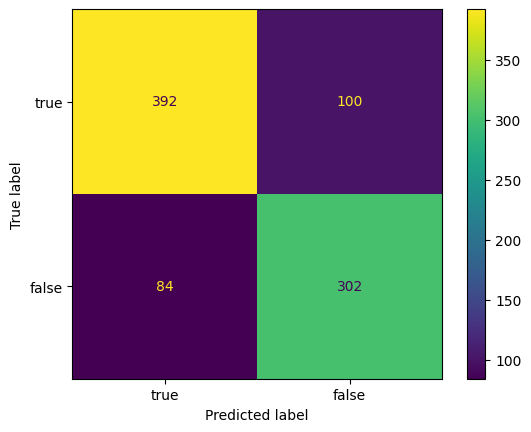

In [152]:
f = predict_points(X_test)
check_score(y_test, f)